<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## DIRECT Consortium Meeting 

## Training GAN for 2D Channel Reservoir

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)

#### Honggeun Jo, Graduate Candidate, The University of Texas at Austin

##### [LinkedIn](https://www.linkedin.com/in/honggeun-jo/?originalSubdomain=kr) | [GitHub](https://github.com/whghdrms) | [Twitter](https://twitter.com/HonggeunJ)


### Workflow for training GAN to extract major patterns in 2D channel reservoir.  
This workflow demonstrate training of GAN [(Goodfellow et al., 2014)](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) for 2D channel reservoir. The 2D channel reservoir models are generated from multipoint statistics (MPS), which is wildly used for facies modeling. MPS uses a training image and mimics the main patterns in the training image to generates realizations through search tree algorithm. Details are [here](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2017WR021078).

## List of library (link included)
Fist of all, we need to load the required libraries, such as 

* [numpy](https://numpy.org/): To generate arrays <br>
* [matplotlib](https://matplotlib.org/): Vilsualization purpose <br>
* [tensorflow and Keras](https://www.tensorflow.org/learn): Design, compile and train neural network models
* os: to update working directory 

In [23]:
# Load library:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import model_from_yaml
import os

# Change working directory, if needed:
# os.chdir(' ')

# This is for making directories where to save trained model and snapshots:
if os.path.isdir('Trained Models') == False:
    os.mkdir('Trained Models')
if os.path.isdir('snapshots') == False:
    os.mkdir('snapshots')

In [24]:
# Load both training image and MPS 500 MPS realizations 
Loaded_data = np.load('MPS_Training_image_and_Realizations_500.npz')
TI = Loaded_data['array1']
MPS_real = Loaded_data['array2']

Text(0, 0.5, 'Y axis, 100 ft')

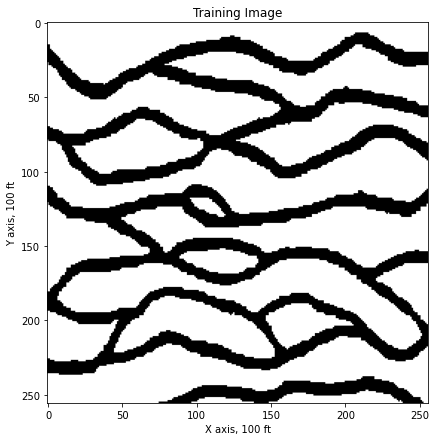

In [25]:
# Visualizae Training image for 2D channel subsurface model:
plt.figure(figsize = (7,7))
plt.imshow(TI, cmap='binary')
plt.title('Training Image')
plt.xlabel('X axis, 100 ft')
plt.ylabel('Y axis, 100 ft')

For more details of GSLIB: https://github.com/GeostatsGuy/GeostatsPy

Total Number of realizations: 500 
The dimension of each reservoir model: 128 x 128 in X and Y


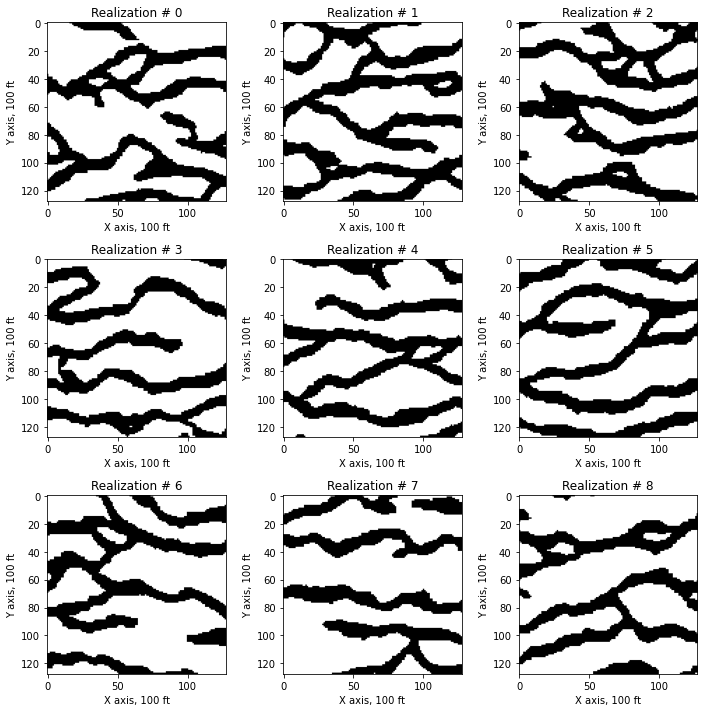

In [26]:
# Visualizae MPS realizations from the above training image:
print('Total Number of realizations: %d \nThe dimension of each reservoir model: %d x %d in X and Y' %(MPS_real.shape[2],MPS_real.shape[0], MPS_real.shape[1]))

plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(MPS_real[:,:,i], cmap='binary')
    plt.title('Realization # %d' %(i))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')
plt.tight_layout()

## Step 1. Define convolutional neural networks for GAN (i.e., Generator and Discriminator)
First we need to define the structure of Generative adversarial network (GAN) to learn the main pattern from the above realizations. Following figure shows the schematic diagram of GAN. 

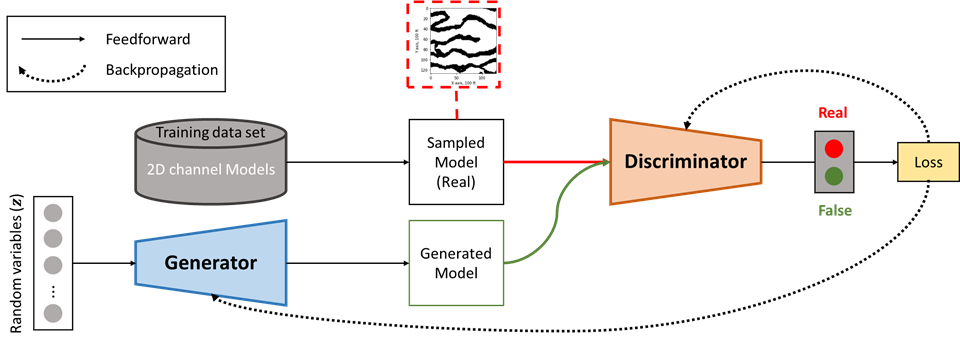

Here, both **Generator** and **Discriminator** are convolutional neural networks. **Generator** maps a latent random vector (consists of 100 random variables that follow Gaussian, N(0,1)) to rule-based model whose dimension is 128 x 128 grid cells in x- and y- direction. On the other hands, **discriminator** takes a subsurface model (from either dataset or generator) and compute the probability the input model to be realistic (i.e., having major patterns within training dataset.) 

In [27]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Conv2DTranspose
import sys

class GAN():
    def __init__(self):
        # Input shape
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        
        # Feature map 1: 100 --> (8x8x64), where (width x height x # of channel)
        model.add(Dense(64 * 8 * 8, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((8, 8, 64)))
        
        # Feature map 2: (8x8x64) --> (16x16x32)
        model.add(Conv2DTranspose(32, kernel_size=4, strides=(2,2), padding = "same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        # Feature map 3: (16x16x32) --> (32x32x16)
        model.add(Conv2DTranspose(16, kernel_size=4, strides=(2,2), padding = "same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        # Feature map 4: (32x32x16) --> (64x64x8)
        model.add(Conv2DTranspose(8, kernel_size=4, strides=(2,2), padding = "same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        # Feature map 5: (64x64x8) --> (128x128x4)
        model.add(Conv2DTranspose(4, kernel_size=4, strides=(2,2), padding = "same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        
        # Feature map 6: (128x128x4) --> (128x128x1)
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("sigmoid"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        # Feature map 1: (128x128x1) --> (64x64x8)
        model.add(Conv2D(8, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        # Feature map 2: (64x64x8) --> (32x32x16)
        model.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        # Feature map 3: (32x32x16) --> (16x16x32)
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        # Feature map 4: (16x16x32) --> (8x8x64)
        model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        
        # Feature map 4: (8x8x64) --> 1 (either 1 (for real) or 0 (for fake))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, epochs, batch_size=128, save_interval=50, save_acc_interval=10):

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # To save accuracy of fake and real data
        accuracy_curve = []
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
                self.save_model(epoch)
            if epoch % save_acc_interval ==0:
                acc = self.save_acc(X_train)
                accuracy_curve.append(acc)
        return accuracy_curve
                
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='binary')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("Snapshots/mnist_%d.png" % epoch)
        plt.close()
        
    def save_model(self, epoch):
        self.generator.save('Trained Models/Generator_Epoch_%d' %epoch )
        
    def save_acc(self, X_train):
        X_fake = self.generator.predict(np.random.normal(0,1,(500,100))).reshape(500,128,128,1)
        _, acc_real = self.discriminator.evaluate(X_train, np.ones((500,1)), verbose = 0)
        _, acc_fake = self.discriminator.evaluate(X_fake, np.zeros((500,1)), verbose = 0)
        return [acc_real, acc_fake]

In [28]:
# Instanciate
gan = GAN()

# Load training data
X_train = MPS_real.reshape(128,128,1,500)
X_train = np.moveaxis(X_train,-1,0)

# Training GAN
accuracy_curve = gan.train(X_train = X_train, epochs=10001, batch_size=32, save_interval=100, save_acc_interval=10)    

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 64, 64, 8)         80        
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 64, 64, 8)         0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 16)        1168      
_________________________________________________________________
batch_normalization_36 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 32, 32, 16)      

C:\Users\jhg13\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\jhg13\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## Step 2. Load the trainined GAN 
Now we load the trained generator and compare GAN realizations with MPS models. First we will do visual inspection on both models depending on GAN's training process. After that, we will use multi-dimensional scaling to visualize reservoir models in 2D space and analyze similarity between MPS and GAN realizations.

In [9]:
from keras.models import load_model # this is for loading NN models 

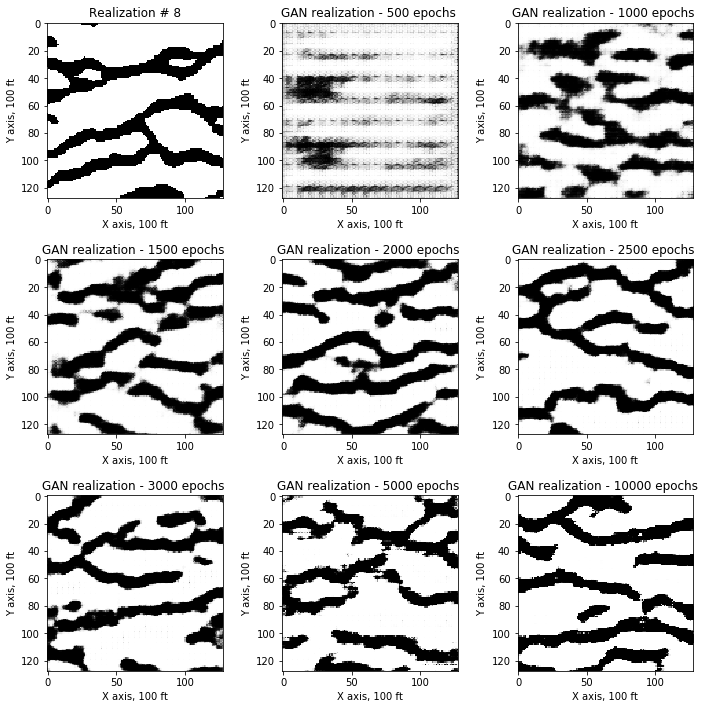

In [43]:
# Visual insepction
plt.figure(figsize = (10,10))
plt.subplot(3,3,1)
plt.imshow(MPS_real[:,:,i], cmap='binary')
plt.title('Realization # %d' %(i))
plt.xlabel('X axis, 100 ft')
plt.ylabel('Y axis, 100 ft')

epochs = [0,500,1000,1500,2000,2500,3000,5000,10000]
for i in range(1,9):
    plt.subplot(3,3,i+1)
    Generator = load_model('Trained Models/Generator_Epoch_%d' % epochs[i])
    GAN_realization = Generator.predict(np.random.normal(0,1,(1,100))).reshape(128,128)
    plt.imshow(GAN_realization, cmap='binary')
    plt.title('GAN realization - %d epochs ' %(epochs[i]))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')

plt.tight_layout()

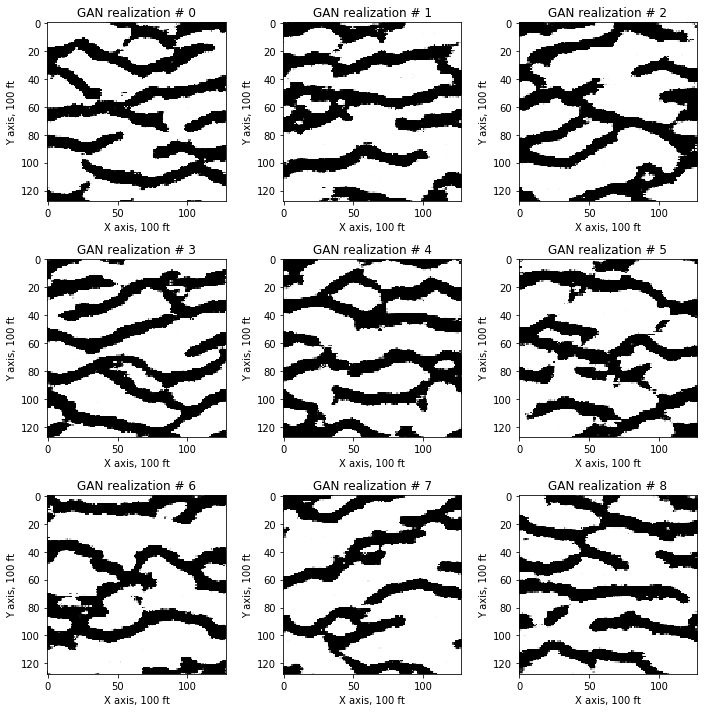

In [49]:
# Load Generator
Generator = load_model('Trained Models/Generator_Epoch_10000')
GAN_realization = Generator.predict(np.random.normal(0,1,(9,100))).reshape(9,128,128)

plt.figure(figsize = (10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(GAN_realization[i, :,:], cmap='binary')
    plt.title('GAN realization # %d' %(i))
    plt.xlabel('X axis, 100 ft')
    plt.ylabel('Y axis, 100 ft')
plt.tight_layout()

C:\Users\jhg13\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
C:\Users\jhg13\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
C:\Users\jhg13\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
C:\Users\jhg13\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training conf

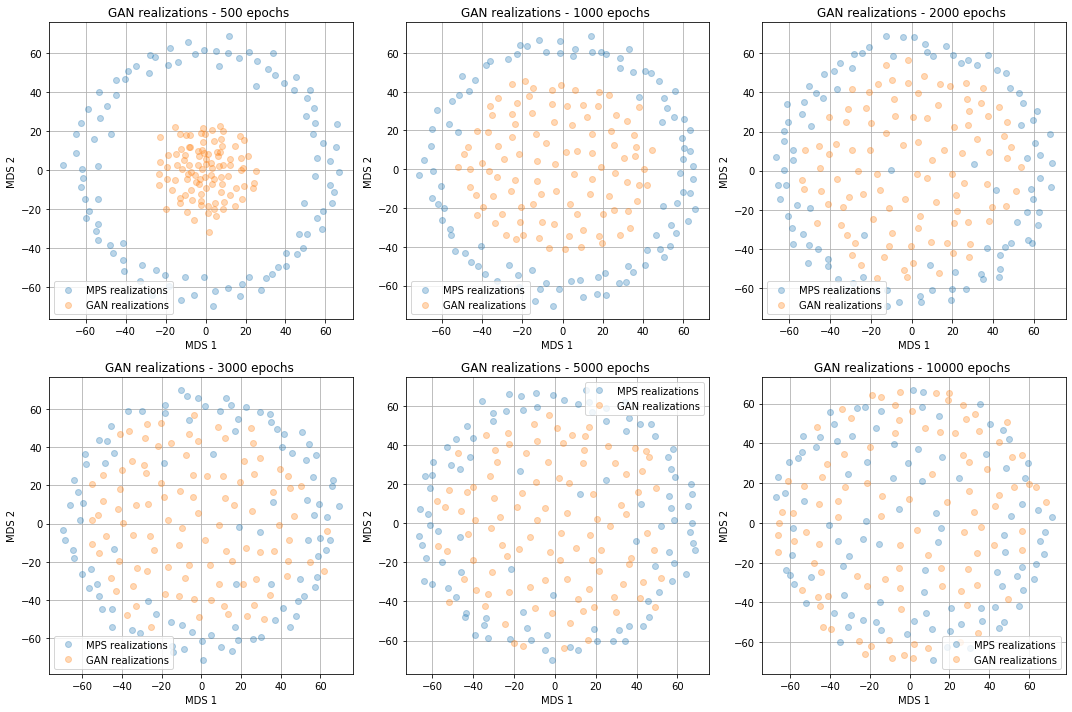

In [47]:
# Visualize similarity in 2D space (MDS)
from sklearn.manifold import MDS
mds = MDS(random_state=123)
MPS_realizations = X_train.reshape(500,-1)[:100]

plt.figure(figsize=(15,10))
epochs = [500,1000,2000,3000,5000,10000]
for i in range(6):
    # Map to 2D space
    Generator = load_model('Trained Models/Generator_Epoch_%d' % epochs[i])
    GAN_realizations = Generator.predict(np.random.normal(0,1,(100,100))).reshape(100,-1)
    mds_array = np.concatenate([MPS_realizations, GAN_realizations], axis = 0)
    mds_2D = mds.fit_transform(mds_array)
    
    plt.subplot(2,3,i+1)
    plt.plot(mds_2D[:100,0],mds_2D[:100,1],'o', alpha = 0.3, label = 'MPS realizations')
    plt.plot(mds_2D[100:,0],mds_2D[100:,1],'o', alpha = 0.3, label = 'GAN realizations')
    plt.title('GAN realizations - %d epochs ' %(epochs[i]))
    plt.grid('on')
    plt.xlabel('MDS 1')
    plt.ylabel('MDS 2')
    plt.legend()
    
plt.tight_layout()

## Benefits of using GAN for subsurface models
1. We can represent realizations with the smaller number of numeric values (~100). **Dimensionality reduction**.
2. ...which means we can now represent qualitative information (we had in training dataset) using quantitative values.
3. As we can represent realizations with a numeric expression, we can easily apply optimization or history matching to GAN realization. 
4. GAN gaurantees that any new realizations conserve the major geological pattern we had in training dataset. **Navigation in manifold**.
5. Flexibility of GAN enable expanding its application to any type of subsurface model (e.g., 3D, channel, lobe, detaic, etc)

#### Comments

The Texas Center for Geostatistics has many other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available [here](https://github.com/GeostatsGuy/PythonNumericalDemos), along with a package for geostatistics in Python called [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy). 
  
We hope this was helpful,

*Michael* and *Honggeun*

***

#### More on Michael Pyrcz and the Texas Center for Data Analytics and Geostatistics:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)


### for any further comments or questions, please contact Dr. Pyrcz via mpyrcz@austin.utexas.edu